# pki_nn_models.ipynb
The purpose of this file is to a neural network model based on the pki dataset. Since the pki dataset is imbalanced, upsampling will be performed frist followed by the model training 

## Upsampling the data

d_X shape:  (292422, 26)
d_y shape:  (292422, 1)

X_train shape:  (204695, 26)
X_test shape:  (87727, 26)
y_train shape:  (204695, 1)
y_test shape:  (87727, 1)


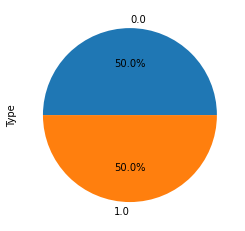

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

pki_df = pd.read_csv("../MLP2/input/heart_2020_normalized.csv")
x_columns = ['BMI', 'Smoking', 'AlcoholDrinking', 'Stroke', \
    'PhysicalHealth', 'MentalHealth', 'DiffWalking', 'Sex', 'AgeCategory', \
    'PhysicalActivity', 'GenHealth', 'SleepTime', 'Asthma', 'KidneyDisease', \
    'SkinCancer', 'American Indian/Alaskan Native', 'Asian', 'Black', \
    'Hispanic', 'Other', 'White', 'No diabetes', 'Borderline diabetes', \
    'Has diabetes', 'Has diabetes (during pregnancy)', 'No diabetes']
y_columns = ['HeartDisease']
target_names = ['No Heart Disease', 'Has Heart Disease']

positive_df = pki_df[pki_df['HeartDisease'] == 1]
negative_df = pki_df[pki_df['HeartDisease'] == 0]

tmp = resample(negative_df, replace=True, n_samples=int(len(negative_df) / 2), random_state=42)
upsample = resample(positive_df, replace=True, n_samples=len(tmp), random_state=42)
upsampled_df = pd.concat([tmp, upsample])
upsampled_df.groupby('HeartDisease').size().plot(kind='pie', y='HeartDisease', label='Type', autopct='%1.1f%%')

u_X = np.c_[upsampled_df[x_columns]]
u_y = np.c_[upsampled_df[y_columns]]

print("d_X shape: ", u_X.shape)
print("d_y shape: ", u_y.shape)

uX_train, uX_test, uy_train, uy_test = train_test_split(u_X, u_y, test_size=0.3, random_state=42)
print("\nX_train shape: ", uX_train.shape)
print("X_test shape: ", uX_test.shape)
print("y_train shape: ", uy_train.shape)
print("y_test shape: ", uy_test.shape)

## Training the MLP Classifier

In [2]:
from dataclasses import dataclass

@dataclass
class MetricContainer:
    name: str
    precision: float = 0
    recall: float = 0
    f1_score: float = 0

def average_classification_report(arr: list):
    no_hd = MetricContainer('No Heart Disease')
    has_hd = MetricContainer('Has Heart Disease')

    for elem in arr:
        no_hd.precision += elem['No Heart Disease']['precision']
        no_hd.recall += elem['No Heart Disease']['recall']
        no_hd.f1_score += elem['No Heart Disease']['f1-score']

        has_hd.precision += elem['Has Heart Disease']['precision']
        has_hd.recall += elem['Has Heart Disease']['recall']
        has_hd.f1_score += elem['Has Heart Disease']['f1-score']   

    size = len(arr)
    no_hd.precision /= size
    no_hd.recall /= size
    no_hd.f1_score /= size

    has_hd.precision /= size
    has_hd.recall /= size
    has_hd.f1_score /= size

    print(no_hd)
    print(has_hd)

    return has_hd.recall
    
def find_optimal_value(values: list, report: list) -> int:
    optimal_value = values[0]
    recall = report[0]

    for idx, val in enumerate(values[0:]):
        if (report[idx] > recall):
            optimal_value = val
            recall = report[idx]
    return optimal_value

In [3]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3, random_state=None, shuffle=True)

In [5]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [100, 500, 1000]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=iter, random_state=42)
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.7980806196687099, recall=0.7259221694413034, f1_score=0.7598314196400837)
MetricContainer(name='Has Heart Disease', precision=0.7480425812164181, recall=0.81484240749396, f1_score=0.779673126369377)
Average report at iter =  500
MetricContainer(name='No Heart Disease', precision=0.7943308388036908, recall=0.7307523108422789, f1_score=0.7612014597408487)
MetricContainer(name='Has Heart Disease', precision=0.7499366260144295, recall=0.8101370242901099, f1_score=0.7788637288840597)
Average report at iter =  1000
MetricContainer(name='No Heart Disease', precision=0.7894745086635827, recall=0.7397750647755729, f1_score=0.7637784520672589)
MetricContainer(name='Has Heart Disease', precision=0.7544206107919345, recall=0.8019407981463704, f1_score=0.7774266074750912)
100


Optimal is 100 iterations

# Optimal number of units

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [20, 50, 100, 150, 200]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(iter))
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)

Average report at iter =  20
MetricContainer(name='No Heart Disease', precision=0.7981820523365802, recall=0.7169716280465854, f1_score=0.754961098970888)
MetricContainer(name='Has Heart Disease', precision=0.7425104420316521, recall=0.8173329023369815, f1_score=0.77781829456009)
Average report at iter =  50
MetricContainer(name='No Heart Disease', precision=0.7906679757763446, recall=0.7315717497149596, f1_score=0.7599282878050097)
MetricContainer(name='Has Heart Disease', precision=0.7494979550792403, recall=0.8056209437251415, f1_score=0.7765117440306003)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  100
MetricContainer(name='No Heart Disease', precision=0.7911089501412977, recall=0.7346952515116353, f1_score=0.7618301384317915)
MetricContainer(name='Has Heart Disease', precision=0.751589663730368, recall=0.8053042654668731, f1_score=0.7774976478918916)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  150
MetricContainer(name='No Heart Disease', precision=0.803571511950839, recall=0.719165253986863, f1_score=0.7588427353469703)
MetricContainer(name='Has Heart Disease', precision=0.745199257918692, recall=0.823358672674943, f1_score=0.7821999482757812)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  200
MetricContainer(name='No Heart Disease', precision=0.7908801709243996, recall=0.7398106184694445, f1_score=0.7644393864239022)
MetricContainer(name='Has Heart Disease', precision=0.7548205542660064, recall=0.8037037608633382, f1_score=0.7784478915823522)
150


optimal is 150

# Look for optimal layer number

In [8]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [(150), (150, 150), (150, 150, 150), (150, 150, 150, 150)]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=iter)
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  150
MetricContainer(name='No Heart Disease', precision=0.7959102306023679, recall=0.7321026021907526, f1_score=0.762518284968872)
MetricContainer(name='Has Heart Disease', precision=0.7513033396123537, recall=0.8113940102502798, f1_score=0.7800722356895905)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  (150, 150)
MetricContainer(name='No Heart Disease', precision=0.8251563153622392, recall=0.755129745995406, f1_score=0.7885500525681722)
MetricContainer(name='Has Heart Disease', precision=0.7736324947004238, recall=0.8393943760803504, f1_score=0.8051424638998155)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  (150, 150, 150)
MetricContainer(name='No Heart Disease', precision=0.8462089669649749, recall=0.7855012842520656, f1_score=0.8147033720985831)
MetricContainer(name='Has Heart Disease', precision=0.7992325931856915, recall=0.8566990208089095, f1_score=0.8269514531492699)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  (150, 150, 150, 150)
MetricContainer(name='No Heart Disease', precision=0.8562908583635561, recall=0.7819572410358594, f1_score=0.8173597106353266)
MetricContainer(name='Has Heart Disease', precision=0.7987980426584533, recall=0.8681805552642846, f1_score=0.8319878335166199)
(150, 150, 150, 150)


Optimal is (150, 150, 150, 150) however (150) will be used for other optimality tests due to training time

# Optimal Activation functions

In [9]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = ["tanh", "relu", "logistic"]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(150), activation=iter)
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  tanh
MetricContainer(name='No Heart Disease', precision=0.789937521681673, recall=0.7309611999690633, f1_score=0.7590581143184684)
MetricContainer(name='Has Heart Disease', precision=0.7489805993037546, recall=0.8044178865568039, f1_score=0.775526496780124)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  relu
MetricContainer(name='No Heart Disease', precision=0.7975743712872196, recall=0.7288836818734561, f1_score=0.7612854835007642)
MetricContainer(name='Has Heart Disease', precision=0.749833216707891, recall=0.8138243507235977, f1_score=0.7802263285517016)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  logistic
MetricContainer(name='No Heart Disease', precision=0.7844076566093122, recall=0.7364921346016388, f1_score=0.7596699380664745)
MetricContainer(name='Has Heart Disease', precision=0.7508911094740355, recall=0.796876990833218, f1_score=0.773179731823373)
relu


optimal is relu

# Optimal Alpha value

In [10]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 1]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(150), alpha=iter)
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.0001
MetricContainer(name='No Heart Disease', precision=0.7846674415171041, recall=0.7479140383796863, f1_score=0.765527941730924)
MetricContainer(name='Has Heart Disease', precision=0.758629903625485, recall=0.7936048393412181, f1_score=0.7754444431155284)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.0005
MetricContainer(name='No Heart Disease', precision=0.7959246743079998, recall=0.7319532634433316, f1_score=0.7624883940109112)
MetricContainer(name='Has Heart Disease', precision=0.7512019317905955, recall=0.8115589845152794, f1_score=0.7801305794998847)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.001
MetricContainer(name='No Heart Disease', precision=0.7965933384866016, recall=0.7271347632444692, f1_score=0.7602170773686961)
MetricContainer(name='Has Heart Disease', precision=0.7482380013700709, recall=0.8135290491359033, f1_score=0.7794741993363249)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.005
MetricContainer(name='No Heart Disease', precision=0.7977938960261737, recall=0.7264594268405773, f1_score=0.7604486596637506)
MetricContainer(name='Has Heart Disease', precision=0.7481492330552868, recall=0.8152343047241364, f1_score=0.7802469660769322)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.01
MetricContainer(name='No Heart Disease', precision=0.7935167050261529, recall=0.7302560033428387, f1_score=0.7605615328966877)
MetricContainer(name='Has Heart Disease', precision=0.7493919196189669, recall=0.80929058118087, f1_score=0.7781824988716289)
Average report at iter =  0.05
MetricContainer(name='No Heart Disease', precision=0.7963113195286198, recall=0.7186207619400409, f1_score=0.7546779572665406)
MetricContainer(name='Has Heart Disease', precision=0.7432054127677286, recall=0.8139801234797188, f1_score=0.7764135152775976)
Average report at iter =  0.1
MetricContainer(name='No Heart Disease', precision=0.7954790068534803, recall=0.7190847496386671, f1_score=0.7552315838813554)
MetricContainer(name='Has Heart Disease', precision=0.7430057884907416, recall=0.8141904148724333, f1_score=0.7768930027924966)
Average report at iter =  1
MetricContainer(name='No Heart Disease', precision=0.7692092110293101, recall=0.7498906653428602, f1_score=0.75931822

0.005 is optimal

# optimal learning rate

In [11]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

iter_values = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 1]
iter_report = []

for iter in iter_values:
    clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(150), alpha=0.005, learning_rate_init=iter)
    report = []
    for train_id, test_id in kf.split(uX_train):
        
        X_train_kf, X_test_kf = uX_train[train_id], uX_train[test_id]
        y_train_kf, y_test_kf = uy_train[train_id], uy_train[test_id]

        clf.fit(X_train_kf, y_train_kf.ravel())

        y_pred = clf.predict(X_test_kf)

        report.append(classification_report(y_test_kf, y_pred, target_names=target_names, output_dict=True))
    print("Average report at iter = ", iter)
    iter_report.append(average_classification_report(report))

optimal_iter_MLP = find_optimal_value(iter_values, iter_report)
print(optimal_iter_MLP)

Average report at iter =  0.0001
MetricContainer(name='No Heart Disease', precision=0.7929996409738972, recall=0.726283269936256, f1_score=0.7581761636756381)
MetricContainer(name='Has Heart Disease', precision=0.7467454137154732, recall=0.8097786798688777, f1_score=0.7769854307979628)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.0005
MetricContainer(name='No Heart Disease', precision=0.7907032898101759, recall=0.7348569776335925, f1_score=0.761645370711178)
MetricContainer(name='Has Heart Disease', precision=0.7516679926476261, recall=0.8045921111328068, f1_score=0.7771463756537426)


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Average report at iter =  0.001
MetricContainer(name='No Heart Disease', precision=0.78968449772502, recall=0.7365848514948107, f1_score=0.7620175828700803)
MetricContainer(name='Has Heart Disease', precision=0.7525134480865937, recall=0.8027798725583425, f1_score=0.7766828871076354)
Average report at iter =  0.005
MetricContainer(name='No Heart Disease', precision=0.7934437932470693, recall=0.7267109542601533, f1_score=0.7585568616936936)
MetricContainer(name='Has Heart Disease', precision=0.7471326902650363, recall=0.8101051152097157, f1_score=0.7773017989049119)
Average report at iter =  0.01
MetricContainer(name='No Heart Disease', precision=0.7915685693864317, recall=0.724304532428197, f1_score=0.7560846420429671)
MetricContainer(name='Has Heart Disease', precision=0.745244710457829, recall=0.8079579692645216, f1_score=0.7750604312779469)
Average report at iter =  0.05
MetricContainer(name='No Heart Disease', precision=0.7840799937943151, recall=0.7264537984684084, f1_score=0.7522

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Average report at iter =  1
MetricContainer(name='No Heart Disease', precision=0.16647369475262955, recall=0.3333333333333333, f1_score=0.2220506254052346)
MetricContainer(name='Has Heart Disease', precision=0.33230742173760114, recall=0.6666666666666666, f1_score=0.4435311929244368)
0.005


c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

0.005 is the best

# Evaluate performance

In [12]:
clf = MLPClassifier(max_iter=100, random_state=42, hidden_layer_sizes=(150, 150, 150, 150), alpha=0.0005, learning_rate_init=0.005)
clf.fit(uX_train, uy_train.ravel())
y_pred = clf.predict(uX_test)
confusion_mat = confusion_matrix(uy_test, y_pred, labels=[1, 0])
print(confusion_mat, "\n\n")

print(classification_report(uy_test, y_pred, target_names=target_names))

class_report = classification_report(uy_test, y_pred, target_names=target_names, output_dict=True)

class_df = pd.DataFrame(class_report).transpose()
class_df.to_csv('./NN_results/pki_nn_classification_report_test.csv')

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


[[36932  7102]
 [10835 32858]] 


                   precision    recall  f1-score   support

 No Heart Disease       0.82      0.75      0.79     43693
Has Heart Disease       0.77      0.84      0.80     44034

         accuracy                           0.80     87727
        macro avg       0.80      0.80      0.80     87727
     weighted avg       0.80      0.80      0.80     87727



Accuracy =  0.8702161509407458


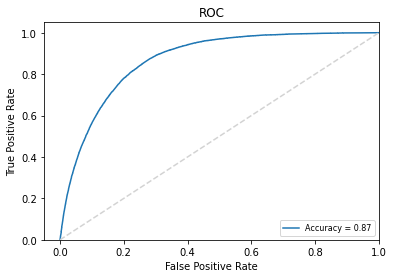

In [13]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_score = clf.predict_proba(uX_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(uy_test, y_score[:,1])

roc_auc = auc(false_positive_rate, true_positive_rate)

print('Accuracy = ', roc_auc)

# Plotting
plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, label=('Accuracy = %0.2f'%roc_auc))
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='lightgrey', linestyle='--')
plt.xlim([-0.05,1.0])
plt.ylim([0.0,1.05])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("./NN_results/pki_nn_roc_test.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()

c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Mason\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the opti

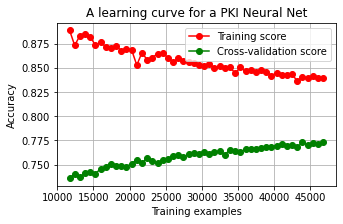

In [14]:
train_sizes = np.linspace(0.2, 0.8, 50)

train_sizes, train_mse, test_mse = learning_curve(clf, uX_test, uy_test.ravel(), 
                                    train_sizes = train_sizes, 
                                    scoring='accuracy', 
                                    cv=3, shuffle=True)

train_scores = train_mse
test_scores = test_mse

#print(train_scores)
#print(test_scores)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Plot learning curve
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
    
ax.set_title('A learning curve for a PKI Neural Net')
ax.set_xlabel("Training examples")
ax.set_ylabel("Accuracy")
ax.grid()

ax.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
ax.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
ax.legend(loc="best")

plt.savefig("./results/NN_pki_learning_curve.png", bbox_inches='tight', transparent=False, facecolor='white')
plt.show()